In [1]:
import importlib.util
from pycolator import *
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
import matplotlib as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

spec = importlib.util.spec_from_file_location("pycolator", "pycolator.py")
pc = importlib.util.module_from_spec(spec)
spec.loader.exec_module(pc)

idCol = 'SpecId'
scoreCol = 'NuXL:score'
excluded = ['SpecId', 'Label', 'ScanNr', 'Peptide', 'Proteins', 'FDR', 'q-val', 'class-specific_q-val', 'Rank']

dSlow = pc.readAndProcess('../data/1-AChernev_080219_dir_HeLa_cyt_UCGA_slow.tsv', idCol, scoreCol, excludedCols = excluded)

file read...
strings converted to floats...
q-values estimated...
ranks computed...
features normed...
floats converted to int...
file ready!


In [2]:
############################################################
# filter out features with very high correlation and set zeros in cross-link column to NaN

header=dSlow.drop(excluded, axis=1).columns.tolist()
#print(len(header))
#print(header)

# drop lower ranks
dSlow = dSlow[dSlow["Rank"]==1]
X = dSlow.drop(excluded, axis=1)

y = dSlow.Label

def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

#correlation(X, 0.95)
#reduced_header = [x for x in header if x in X.columns]
#X=X[reduced_header]

# set zeros in XL columns of non-cross-links to nan
xl_features = [x for x in X.columns if "NuXL:pl_" in x or "tag_" in x or "NuXL:marker_ions_score" in x or "NuXL:partial_loss_score" in x]
X.loc[X["NuXL:isXL"]==0, xl_features] = np.nan

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [3]:
############################################################
# estimate sample weights

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

#print(X_train.head())
#print(y_train.head())

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

print(train.columns)

train_nXL_t=sum((train["NuXL:isXL"]==1.0) & (train["Label"] == 1.0))
train_nXL_d=sum((train["NuXL:isXL"]==1.0) & (train["Label"] == 0.0))

train_nPep_t=sum((train["NuXL:isXL"]==0.0) & (train["Label"] == 1.0))
train_nPep_d=sum((train["NuXL:isXL"]==0.0) & (train["Label"] == 0.0))

wXL_t = (train_nXL_t - train_nXL_d) / train_nXL_d
wPep_t = (train_nPep_t - train_nPep_d) / train_nPep_d

print("Peptide targets: " + str(train_nPep_t))
print("Peptide decoys: " +  str(train_nPep_d))
print("XL targets: " + str(train_nXL_t))
print("XL decoys: " +  str(train_nXL_d))

print("Weight peptides: " + str(wPep_t))
print("Weight XLs: " +  str(wXL_t))

def getWeights(Xy, wPep, wXL):
    print(Xy.columns)
    weights = list()
    for index, row in Xy.iterrows():
        #print(row)
        if row.loc["Label"] < 0.5: # decoy
            weights.append(1.0)
            continue       
        if row.loc["NuXL:isXL"] > 0.5:
            weights.append(wXL)
            continue
        else:
            weights.append(wPep)
            continue
    return weights

train_sample_weights = getWeights(train, wPep_t, wXL_t)
test_sample_weights = getWeights(test, wPep_t, wXL_t)


data = pd.concat([X, y], axis=1)
all_nXL_t=sum((data["NuXL:isXL"]==1.0) & (data["Label"] == 1.0))
all_nXL_d=sum((data["NuXL:isXL"]==1.0) & (data["Label"] == 0.0))

all_nPep_t=sum((data["NuXL:isXL"]==0.0) & (data["Label"] == 1.0))
all_nPep_d=sum((data["NuXL:isXL"]==0.0) & (data["Label"] == 0.0))

wXL_t = (all_nXL_t - all_nXL_d) / all_nXL_d
wPep_t = (all_nPep_t - all_nPep_d) / all_nPep_d
all_sample_weights = getWeights(data, wPep_t, wXL_t)


#print(train_sample_weights)
assert len(train_sample_weights) == len(X_train), "sample weights should match training data size'"


Index(['ExpMass', 'CalcMass', 'mass', 'peplen', 'charge2', 'charge3',
       'charge4', 'charge5', 'enzN', 'enzC', 'enzInt', 'dm', 'absdm',
       'NuXL:mass_error_p', 'NuXL:err', 'NuXL:total_loss_score', 'NuXL:modds',
       'NuXL:immonium_score', 'NuXL:precursor_score', 'NuXL:MIC', 'NuXL:Morph',
       'NuXL:total_MIC', 'NuXL:ladder_score', 'NuXL:sequence_score',
       'NuXL:total_Morph', 'NuXL:total_HS', 'NuXL:tag_XLed',
       'NuXL:tag_unshifted', 'NuXL:tag_shifted', 'nr_candidates',
       'NuXL:rank_product', 'NuXL:wTop50', 'NuXL:marker_ions_score',
       'NuXL:partial_loss_score', 'NuXL:pl_MIC', 'NuXL:pl_err',
       'NuXL:pl_Morph', 'NuXL:pl_modds', 'NuXL:pl_pc_MIC', 'NuXL:pl_im_MIC',
       'NuXL:isXL', 'NuXL:score', 'variable_modifications',
       'precursor_intensity_log10', 'NuXL:NA_MASS_z0', 'NuXL:NA_length',
       'nucleotide_mass_tags', 'precursor_purity', 'NuXL:XL_U', 'NuXL:XL_C',
       'NuXL:XL_G', 'NuXL:XL_A', 'Label'],
      dtype='object')
Peptide targets: 276

Accuracy on train data: 0.67
Accuracy on test data: 0.62
[[ 646 2364]
 [ 579 4221]]
Accuracy on train data (sample weight): 0.76
Accuracy on test data (sample weight): 0.68
[[2641  369]
 [2600 2200]]
Index(['ExpMass', 'CalcMass', 'mass', 'peplen', 'charge2', 'charge3',
       'charge4', 'charge5', 'enzN', 'enzC', 'enzInt', 'dm', 'absdm',
       'NuXL:mass_error_p', 'NuXL:err', 'NuXL:total_loss_score', 'NuXL:modds',
       'NuXL:immonium_score', 'NuXL:precursor_score', 'NuXL:MIC', 'NuXL:Morph',
       'NuXL:total_MIC', 'NuXL:ladder_score', 'NuXL:sequence_score',
       'NuXL:total_Morph', 'NuXL:total_HS', 'NuXL:tag_XLed',
       'NuXL:tag_unshifted', 'NuXL:tag_shifted', 'nr_candidates',
       'NuXL:rank_product', 'NuXL:wTop50', 'NuXL:marker_ions_score',
       'NuXL:partial_loss_score', 'NuXL:pl_MIC', 'NuXL:pl_err',
       'NuXL:pl_Morph', 'NuXL:pl_modds', 'NuXL:pl_pc_MIC', 'NuXL:pl_im_MIC',
       'NuXL:isXL', 'NuXL:score', 'variable_modifications',
       'precursor_intensity_log10',

alpha,beta: 0.4	0.8
Accuracy on all data (sample weight): 0.75
[[11805   298]
 [11465  7672]]
Index(['ExpMass', 'CalcMass', 'mass', 'peplen', 'charge2', 'charge3',
       'charge4', 'charge5', 'enzN', 'enzC', 'enzInt', 'dm', 'absdm',
       'NuXL:mass_error_p', 'NuXL:err', 'NuXL:total_loss_score', 'NuXL:modds',
       'NuXL:immonium_score', 'NuXL:precursor_score', 'NuXL:MIC', 'NuXL:Morph',
       'NuXL:total_MIC', 'NuXL:ladder_score', 'NuXL:sequence_score',
       'NuXL:total_Morph', 'NuXL:total_HS', 'NuXL:tag_XLed',
       'NuXL:tag_unshifted', 'NuXL:tag_shifted', 'nr_candidates',
       'NuXL:rank_product', 'NuXL:wTop50', 'NuXL:marker_ions_score',
       'NuXL:partial_loss_score', 'NuXL:pl_MIC', 'NuXL:pl_err',
       'NuXL:pl_Morph', 'NuXL:pl_modds', 'NuXL:pl_pc_MIC', 'NuXL:pl_im_MIC',
       'NuXL:isXL', 'NuXL:score', 'variable_modifications',
       'precursor_intensity_log10', 'NuXL:NA_MASS_z0', 'NuXL:NA_length',
       'nucleotide_mass_tags', 'precursor_purity', 'NuXL:XL_U', 'NuX

alpha,beta: 0.8	0.8
Accuracy on all data (sample weight): 0.73
[[11810   293]
 [11477  7660]]


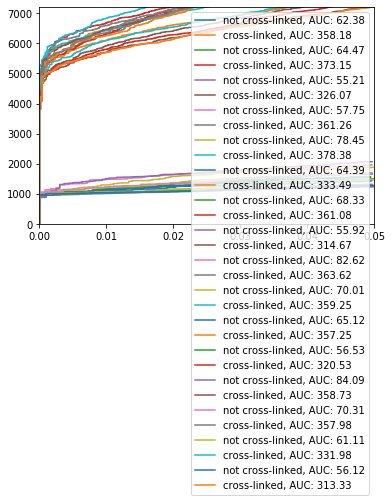

In [7]:
############################################################
# build histogram gradient boosted classifier with monotonicity constraints

# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

monotonic_cst= [0] * len(X.columns)
monotonic_cst[X.columns.tolist().index("absdm")] = -1
monotonic_cst[X.columns.tolist().index("NuXL:mass_error_p")] = 1
monotonic_cst[X.columns.tolist().index("NuXL:err")] = -1
monotonic_cst[X.columns.tolist().index("NuXL:total_loss_score")] = 1
monotonic_cst[X.columns.tolist().index("NuXL:modds")] = 1
monotonic_cst[X.columns.tolist().index("NuXL:precursor_score")] = 1
monotonic_cst[X.columns.tolist().index("NuXL:MIC")] = 1
monotonic_cst[X.columns.tolist().index("NuXL:total_MIC")] = 1
monotonic_cst[X.columns.tolist().index("NuXL:ladder_score")] = 1
monotonic_cst[X.columns.tolist().index("NuXL:sequence_score")] = 1
monotonic_cst[X.columns.tolist().index("NuXL:total_Morph")] = 1
monotonic_cst[X.columns.tolist().index("nr_candidates")] = -1
monotonic_cst[X.columns.tolist().index("NuXL:marker_ions_score")] = 1
monotonic_cst[X.columns.tolist().index("NuXL:pl_err")] = -1
monotonic_cst[X.columns.tolist().index("NuXL:pl_modds")] = 1
#monotonic_cst[X.columns.tolist().index("NuXL:pl_MIC")] = 1
monotonic_cst[X.columns.tolist().index("NuXL:pl_im_MIC")] = 1
monotonic_cst[X.columns.tolist().index("variable_modifications")] = -1
monotonic_cst[X.columns.tolist().index("precursor_intensity_log10")] = 1
monotonic_cst[X.columns.tolist().index("precursor_purity")] = 1

assert len(X_train) == len(y_train), "Row dimension mismatch"
assert len(X_train) == len(train_sample_weights), "Row dimension mismatch"

clf = HistGradientBoostingClassifier(early_stopping=True, scoring="f1", monotonic_cst=monotonic_cst)

# for comparison fit without sample weights
clf.fit(X_train, y_train)
print("Accuracy on train data: {:.2f}".format(clf.score(X_train, y_train)))
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))
print(confusion_matrix(y_test, clf.predict(X_test)))

# now with sample weights
clf.fit(X_train, y_train, sample_weight=train_sample_weights)
print("Accuracy on train data (sample weight): {:.2f}".format(clf.score(X_train, y_train, sample_weight=train_sample_weights)))
print("Accuracy on test data (sample weight): {:.2f}".format(clf.score(X_test, y_test, sample_weight=test_sample_weights)))
print(confusion_matrix(y_test, clf.predict(X_test)))

for alpha in np.arange(0.2, 1.0, 0.2):
    for beta in np.arange(0.2, 1.0, 0.2):
    
    # now on all data
#    clf.fit(X, y)
#    print("Accuracy on all data: {:.2f}".format(clf.score(X, y)))

#    p = clf.predict_proba(data.loc[:, data.columns != 'Label'])[:,1] # prob for class=1 (target)
#    p = pd.DataFrame({'p-value': p })
#    data.reset_index(drop=True, inplace=True)
#    p.reset_index(drop=True, inplace=True)
#    data2 = pd.concat([data, p], axis=1)
#    data2 = calcQ(data2, "p-value")
#    data2["Rank"] = 1
#    evalXL(data2)

        all_sample_weights = getWeights(data, alpha*wPep_t, beta*wXL_t)

        clf.fit(X, y, sample_weight=all_sample_weights)
        print("alpha,beta: " + str(alpha) + "\t" + str(beta))
        print("Accuracy on all data (sample weight): {:.2f}".format(clf.score(X, y, sample_weight=all_sample_weights)))
        print(confusion_matrix(y, clf.predict(X)))

        p = clf.predict_proba(data.loc[:, data.columns != 'Label'])[:,1] # prob for class=1 (target)
        p = pd.DataFrame({'p-value': p })
        data.reset_index(drop=True, inplace=True)
        p.reset_index(drop=True, inplace=True)
        data2 = pd.concat([data, p], axis=1)
        data2 = calcQ(data2, "p-value")
        data2["Rank"] = 1
        evalXL(data2)
